In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("CASP.csv")

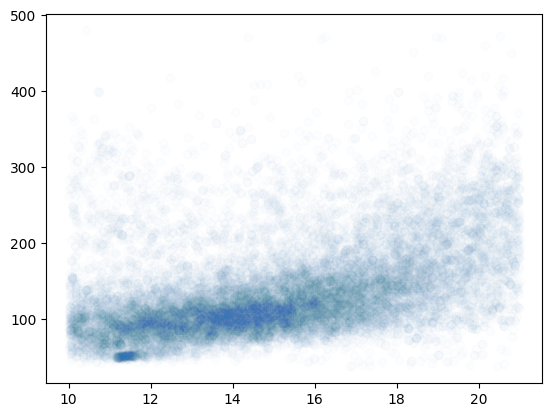

In [44]:
plt_df = df[df['RMSD']>=10]

plt.scatter(plt_df['RMSD'], plt_df['F6'], alpha=0.01)

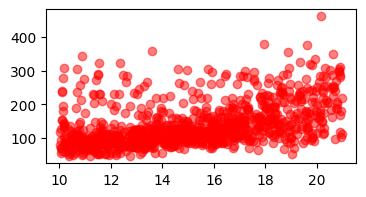

In [77]:
#try the analytic Gaussian fit on a subset of the data

##subselect 500 random points
subset = plt_df.sample(n=1000, random_state=1)

f,ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(subset['RMSD'], subset['F6'], color='red', alpha=0.5)

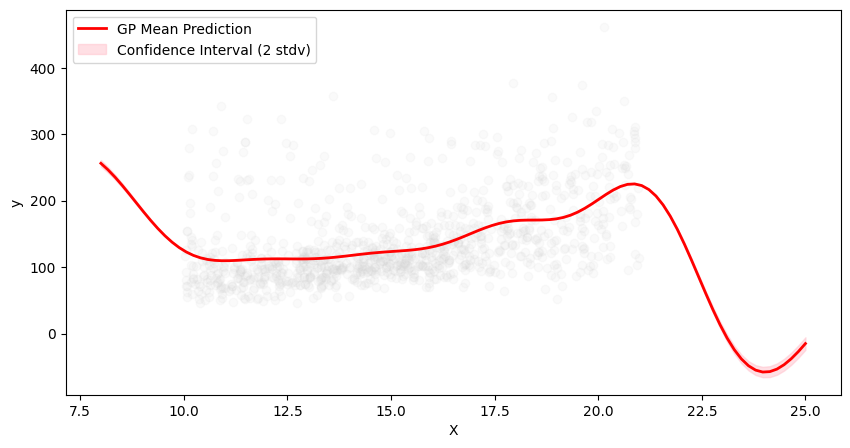

In [87]:
import numpy as np
def kernel_cov(a, b, k=1.0, sig_f=1.0):
    """
    Given two vectors of size N, compute the N x N covariance matrix S as an RBF kernel.

    Where each element S_ij is:

    S_ij = exp(-0.5 * (a_i - b_j)^2)

    To do this in a parallelized way, we take advantage of the fact that:

    ||a - b||^2 = ||a||^2 + ||b||^2 - 2 * a /dot b

    where ||a||^2 is the L2 norm of a vector a (aka the sum of squares of its elements) and a /dot b is the dot product.

    k is a parameter that controls the kernel width
    """
    # compute the squared Euclidean distance
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return sig_f**2*np.exp(-.5 * sqdist / k**2)

def plot_gpr(Xtrain, ytrain, Xinference, sig_noise=1, kernel_width=1, sig_f=5, plot_z=False):
    """
    sig_noise #random amount of noise to add to account for observations - later, we will optimize this
    kernel_width #similar here - we will later optmize this
    sig_f #signal variance - we will optimize this as well
    """

    y_mean = np.mean(ytrain)
    ytrain_centered = ytrain - y_mean

    K = kernel_cov(Xtrain, Xtrain, k=kernel_width, sig_f=sig_f)
    K_y = K + sig_noise**2 * np.eye(len(Xtrain))
    K_s = kernel_cov(Xtrain, Xinference, k=kernel_width, sig_f=sig_f)
    K_ss = kernel_cov(Xinference, Xinference, k=kernel_width, sig_f=sig_f)

    L = np.linalg.cholesky(K_y + 1e-6*np.eye(len(Xtrain)))
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, ytrain_centered))
    y_pred = K_s.T.dot(alpha) + y_mean #mean prediction. Also, add back the mean we subtracted earlier

    v = np.linalg.solve(L, K_s)
    cov_pred = K_ss - v.T.dot(v) #predictive covariance
    stdv_pred = np.sqrt(np.diag(cov_pred)) #standard deviation is sqrt of diagonal elements

    #plot the predictions and the uncertainty
    f,ax = plt.subplots(1,1, figsize=(10, 5))

    ax.scatter(Xtrain, ytrain, color='lightgray', alpha=0.1)
    ax.plot(Xinference, y_pred, 'r', lw=2, label='GP Mean Prediction')
    ax.fill_between(Xinference.flatten(), 
                    (y_pred.squeeze(1) - (2*stdv_pred)).flatten(), 
                    (y_pred.squeeze(1) + (2*stdv_pred)).flatten(), 
                    color='pink', alpha=0.5, label='Confidence Interval (2 stdv)')
    if plot_z:
        ax.fill_between(Xinference.flatten(), 
                    (y_pred.squeeze(1) - (3*stdv_pred)).flatten(), 
                    (y_pred.squeeze(1) - (2*stdv_pred)).flatten(), 
                    color='blue', alpha=0.5, label='Confidence Interval (3 stdv)')
        ax.fill_between(Xinference.flatten(),
                    (y_pred.squeeze(1) + (2*stdv_pred)).flatten(), 
                    (y_pred.squeeze(1) + (3*stdv_pred)).flatten(), 
                    color='blue', alpha=0.5)
        
        
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.legend()


Xtrain = subset['RMSD'].values.reshape(-1,1)
ytrain = subset['F6'].values.reshape(-1,1)
Xinference = np.linspace(8, 25, 100).reshape(-1,1)

plot_gpr(Xtrain, ytrain, Xinference, sig_noise=0.5, kernel_width=2.0, sig_f=5.0)

#notice 1.) how bad the fit is in areas with no data, 2.) how "certain" the model is and 3.) how much the function wiggles around?
    #we want to optimze the parameters for this GPR so as to best fit the data and provide reliable uncertainty estimates

Optimal kernel width (l): 7.493888687530139
Optimal signal variance (sig_f): 116.07023988240097
Optimal noise level (sig_n): 77.0544950976657


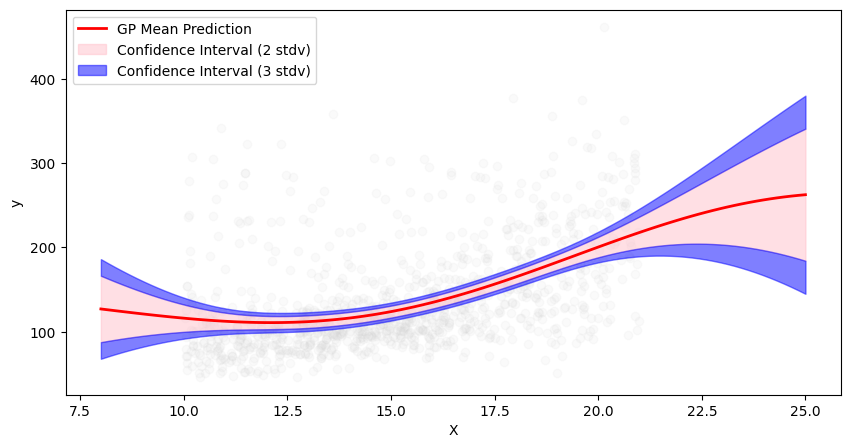

In [88]:
## Now, optimize over the hyperparameters by maximizing the log marginal likelihood
    #l: the kernel width
    #sigma_f: the kernel height
    #sigma_n: the noise level of the observations

from scipy.optimize import minimize

def nll_optimize(theta, X, y):
    """
    Function to find the optimal hyperparameter of GPR by minimizing the negative log likelihood.

    theta: tuple of hyperparameters (l, sig_f, sig_n)
    X: training input data
    y: training output data

    LogLike = (-0.5 * y^T * [K + sig_n^2 I]^-1 * y) - (0.5 * log|K + sig_n^2 I|) - ((n/2) * log(2pi))
        
        K: covariance kernel whose hyperparameters we are optimizing
        sig_n: noise level of the observations
    
    The last term is constant wrt the hyperparameters, so we can ignore it for optimization.
    """
    l, sig_f, sig_n = theta

    K = kernel_cov(X, X, k=l, sig_f=sig_f)
    K_y = K + (sig_n**2) * np.eye(len(X))
    L = np.linalg.cholesky(K_y + 1e-6*np.eye(len(X)))
    #left term becomes 0.5 * y^T * [LL^T]^-1 * y
    left = -0.5 * y.T.dot(np.linalg.solve(L.T, np.linalg.solve(L, y)))

    #right term becomes 0.5 * log|LL^T| = 0.5* sum(log(diag(L)))
        #we use some identities: |AB| = |A||B| and |A^T| = |A|
        #Also, for a triangular matrix, the determinant is the product of the diagonal elements
    right = -0.5 * np.sum(np.log(np.diag(L)))  #log determinant

    log_likelihood = left + right
    return -log_likelihood.flatten() #we minimize the negative log likelihood

#initial guess
initial_theta = (5.0, 5.0, 1.0)

#inputs
Xtrain = subset['RMSD'].values.reshape(-1,1)
ytrain = subset['F6'].values.reshape(-1,1)
ymean = np.mean(ytrain)
ytrain_centered = ytrain - ymean

res = minimize(nll_optimize, initial_theta, args=(Xtrain, ytrain_centered), 
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

l_opt, sig_f_opt, sig_n_opt = res.x

print(f"Optimal kernel width (l): {l_opt}")
print(f"Optimal signal variance (sig_f): {sig_f_opt}")
print(f"Optimal noise level (sig_n): {sig_n_opt}")

plot_gpr(Xtrain, ytrain, Xinference, sig_noise=sig_n_opt, kernel_width=l_opt, sig_f=sig_f_opt, plot_z=True)

#notice how after optimization:
    #the fit is much smoother
    #the uncertainty is much more reasonable (in areas with and without data)
    #inference is (likely) much better in areas without data

In [85]:
## now, how would this kind of model perform on anomaly detection, i.e. zscores?

from scipy.stats import norm

def calculate_z_scores(X_new, y_new, ytrainmean, X_train, L, alpha, k, sig_f):
    """
    X_new: The locations of the new data (N_new, 1)
    y_new: The observed values at those locations (N_new, 1)
    """
    # 1. Get the 'Bridge' kernel between training data and new data
    K_s = kernel_cov(X_train, X_new, k=k, sig_f=sig_f)
    
    # 2. Predict the Mean at the new locations
    # We use the same 'alpha' we calculated during training
    mu_new = K_s.T.dot(alpha)
    
    # 3. Predict the Variance at the new locations
    K_ss = kernel_cov(X_new, X_new, k=k, sig_f=sig_f)
    v = np.linalg.solve(L, K_s)
    cov_new = K_ss - v.T.dot(v)
    std_new = np.sqrt(np.diag(cov_new)).reshape(-1, 1)
    
    # 4. Calculate Z-Scores
    # Note: If you centered your training data, subtract that same mean from y_new!
    z_scores = (y_new - ytrainmean - mu_new) / std_new
    
    # 5. Optional: Convert to Centiles (Percentiles)
    percentiles = norm.cdf(z_scores) * 100
    
    # Identify points that are more than 3 standard deviations away
    outliers = np.abs(z_scores) > 3

    f,ax = plt.subplots(1,1, figsize=(10, 5))
    ax.scatter(X_new, y_new, c=outliers, cmap='coolwarm')
    ax.plot(Xinference, y_pred, 'r', label='GP Model')
    # Plotting the 'Discovery' zones
    plt.fill_between(Xinference, y_pred-2*std, y_pred+2*std, alpha=0.2, label='95% range')

    return z_scores, percentiles

In [86]:
## try the Gaussian Process in pytorch on this data

print(stdv_pred)

[1.02317468 0.91456431 0.81186466 0.715385   0.62537749 0.54203729
 0.46550481 0.39587014 0.33318073 0.27745272 0.2286866  0.18688629
 0.15207462 0.12428355 0.1034693  0.08929854 0.08087621 0.07671375
 0.0751163  0.07466731 0.07444119 0.07395714 0.07304579 0.07172738
 0.07012378 0.06839846 0.0667151  0.06520923 0.06397062 0.06303628
 0.06239382 0.06199308 0.06176234 0.06162484 0.06151231 0.06137414
 0.06118189 0.06093004 0.0606338  0.06032482 0.06004543 0.05984203
 0.05975809 0.05982772 0.06007057 0.06048888 0.06106728 0.06177528
 0.06257199 0.06341237 0.06425397 0.06506343 0.06582204 0.06652976
 0.06720716 0.06789443 0.06864706 0.06952761 0.0705941  0.07188624
 0.07341232 0.07513999 0.07699404 0.07886328 0.0806177  0.08213696
 0.08335257 0.08430808 0.08524216 0.08669167 0.08958423 0.09523707
 0.10515909 0.12068674 0.14270195 0.17162731 0.20760265 0.25065247
 0.30077168 0.35794982 0.42216724 0.49338302 0.57152287 0.65646956
 0.74805627 0.8460625  0.95021237 1.06017461 1.17556428 1.2959

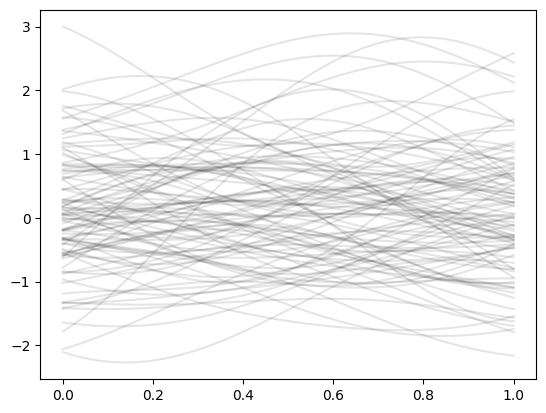

In [30]:
## test for kernel function

import numpy as np

def kernel_cov(a, b, k=1.0):
    """
    Given two vectors of size N, compute the N x N covariance matrix S as an RBF kernel.

    Where each element S_ij is:

    S_ij = exp(-0.5 * (a_i - b_j)^2)

    To do this in a parallelized way, we take advantage of the fact that:

    ||a - b||^2 = ||a||^2 + ||b||^2 - 2 * a /dot b

    where ||a||^2 is the L2 norm of a vector a (aka the sum of squares of its elements) and a /dot b is the dot product.

    k is a parameter that controls the kernel width
    """
    # compute the squared Euclidean distance
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * sqdist / k**2)

n=100 #number of Dimensions
k=100  #number of functions we are sampling

X = np.linspace(0,1,n).reshape(-1,1)

cov = kernel_cov(X, X, k=0.5) #change k to see effect on smoothness

Y = np.random.multivariate_normal(mean=np.zeros(n), cov=cov, size=k).T

f,ax = plt.subplots(1,1)
ax.plot(X, Y, '-k', alpha=0.1)

Text(0.5, 1.0, 'Probability Density at f(0.3)')

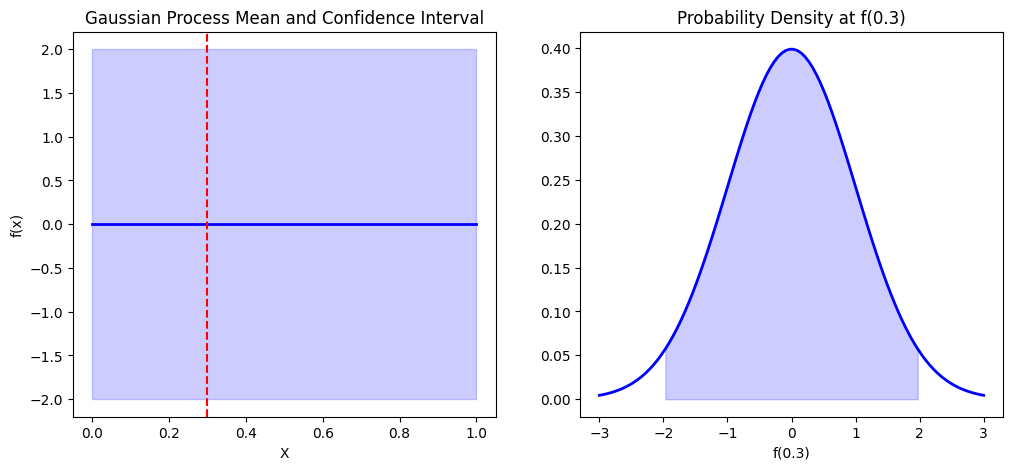

In [39]:
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation
mu = np.zeros(n)
# The variance at each point x is the diagonal of the covariance matrix
std_dev = np.sqrt(np.diag(cov))

# Plot the mean line
f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(X, mu, color='blue', lw=2, label='Mean')

# Plot the 95% confidence interval (2 standard deviations)
ax[0].fill_between(X.flatten(), mu - 2*std_dev, mu + 2*std_dev, color='blue', alpha=0.2, label='95% Confidence')

x0 = 0.3
ax[0].axvline(x=x0, color='red', linestyle='--', label='x=0.5')
ax[0].set_ylabel('f(x)')
ax[0].set_xlabel('X')
ax[0].set_title('Gaussian Process Mean and Confidence Interval')

#on the next axis, plot the distribution of f(0.3)
mean_x0 = 0
std_x0 = np.sqrt(cov[int(x0*n), int(x0*n)])
x_vals = np.linspace(-3*std_x0, 3*std_x0, 100)
from scipy.stats import norm
pdf = norm.pdf(x_vals, loc=mean_x0, scale=std_x0)
ax[1].plot(x_vals, pdf, color='blue', lw=2)
#fill from -2*std to 2*std
ax[1].fill_between(x_vals, 0, pdf, where=(x_vals >= -2*std_x0) & (x_vals <= 2*std_x0), color='blue', alpha=0.2)
ax[1].set_xlabel('f(0.3)')
ax[1].set_title('Probability Density at f(0.3)')